In [1]:
import pandas as pd
import sqlalchemy
from matplotlib import pyplot as plt
import datetime
import copy

In [2]:
db = sqlalchemy.engine.url.URL(drivername='mysql',
                            host='127.0.0.1',
                            database='sherman_1',
                            query={'read_default_file': '~/.my.cnf', 'charset':'utf8'})
engine = sqlalchemy.create_engine(db)

In [3]:
df = pd.read_sql('''
    SELECT * FROM sherman_1.plugin_ios_activity_recognition;
''' ,engine)

In [4]:
df

,_id,timestamp,device_id,activities,confidence,stationary,walking,running,automotive,cycling,unknown,label
0,68901,1.667838e+12,39f277f4-a04c-4668-8a36-8addb0a0265f,"[""stationary""]",2,1,0,0,0,0,0,
1,68902,1.667838e+12,39f277f4-a04c-4668-8a36-8addb0a0265f,"[""stationary""]",2,1,0,0,0,0,0,
2,68903,1.667838e+12,39f277f4-a04c-4668-8a36-8addb0a0265f,"[""stationary""]",2,1,0,0,0,0,0,
3,68904,1.667838e+12,39f277f4-a04c-4668-8a36-8addb0a0265f,"[""stationary""]",2,1,0,0,0,0,0,supplement
4,68905,1.667838e+12,39f277f4-a04c-4668-8a36-8addb0a0265f,,2,0,0,0,0,0,0,
...,...,...,...,...,...,...,...,...,...,...,...,...
4363523,4432424,1.673474e+12,30ca0662-67d1-42d6-9610-d435e60a6a79,"[""stationary""]",2,1,0,0,0,0,0,
4363524,4432425,1.673474e+12,30ca0662-67d1-42d6-9610-d435e60a6a79,,2,0,0,0,0,0,0,
4363525,4432426,1.673474e+12,30ca0662-67d1-42d6-9610-d435e60a6a79,"[""stationary""]",2,1,0,0,0,0,0,
4363526,4432427,1.673474e+12,30ca0662-67d1-42d6-9610-d435e60a6a79,,2,0,0,0,0,0,0,


In [5]:
df['date'] = pd.to_datetime(df['timestamp'],unit='ms').dt.date

In [6]:
df_less = df[df['label'] != 'supplement']
df_less = df[['device_id','date','stationary','walking','running','automotive','cycling','unknown']]

In [7]:
df_output = df_less.groupby(['device_id','date']).sum()
df_output = df_output.reset_index()
df_output

,device_id,date,stationary,walking,running,automotive,cycling,unknown
0,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-18,467,221,2,187,0,0
1,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-19,741,182,0,188,0,0
2,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-20,780,298,6,409,0,0
3,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-21,943,462,1,500,0,0
4,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-22,836,321,1,334,0,0
...,...,...,...,...,...,...,...,...
2646,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-29,1182,184,3,25,0,0
2647,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-30,761,332,6,165,0,0
2648,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-31,967,144,0,450,10,0
2649,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2023-01-01,1376,31,0,0,0,0


In [8]:
df_output.to_csv("ios_activity_cleaned.csv", index = False)

# filter 1-28

In [9]:
def find_first_day(device_id, df_cleaned):
    df_target = df_cleaned[df_cleaned['device_id']==device_id]
    return min(df_target['date'])

In [10]:
def get_1_to_28(df_cleaned):
    first_day = {device_id:find_first_day(device_id, df_cleaned) 
                 for device_id in set(df_cleaned['device_id'].tolist())
                if find_first_day(device_id, df_cleaned)>=datetime.date(year=2022,month=11,day=11)}
    df_cleaned = df_cleaned[df_cleaned['device_id'].isin(first_day)]
    df_cleaned['day'] = df_cleaned.apply(lambda x: 1+(x['date']-first_day[x['device_id']]).days, axis = 1)
    df_cleaned = df_cleaned[df_cleaned['day']<=28]
    return df_cleaned

In [11]:
df_cleaned_1_28 = get_1_to_28(df_output)
df_cleaned_1_28

/home/jch0/.conda/envs/jch0/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,device_id,date,stationary,walking,running,automotive,cycling,unknown,day
0,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-18,467,221,2,187,0,0,1
1,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-19,741,182,0,188,0,0,2
2,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-20,780,298,6,409,0,0,3
3,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-21,943,462,1,500,0,0,4
4,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-22,836,321,1,334,0,0,5
...,...,...,...,...,...,...,...,...,...
2646,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-29,1182,184,3,25,0,0,24
2647,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-30,761,332,6,165,0,0,25
2648,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-31,967,144,0,450,10,0,26
2649,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2023-01-01,1376,31,0,0,0,0,27


# lineplot

In [37]:
df_plot = copy.deepcopy(df_cleaned_1_28)
df_plot = df_plot[['stationary','walking','running','automotive','cycling','unknown','day']]
df_plot['total'] = df_plot.apply(lambda x: x['stationary']+x['walking']+x['running']+x['automotive']+x['cycling']+x['unknown'],
                                axis = 1)
for feature in ['stationary','walking','running','automotive','cycling','unknown']:
    df_plot[feature] = df_plot.apply(lambda x: x[feature]/x['total'], axis = 1)

df_plot = df_plot.drop('total', axis = 1)
df_plot = df_plot.groupby('day').mean()
df_plot = df_plot.reset_index()
df_plot


/home/jch0/.conda/envs/jch0/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  
/home/jch0/.conda/envs/jch0/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


,day,stationary,walking,running,automotive,cycling,unknown
0,1,0.777554,0.086735,0.002080,0.128677,0.004953,0.0
1,2,0.805779,0.087046,0.000701,0.103877,0.002596,0.0
2,3,0.815421,0.077370,0.001008,0.102811,0.003391,0.0
3,4,0.785924,0.076887,0.000631,0.133215,0.003343,0.0
4,5,0.792916,0.081576,0.000514,0.121191,0.003804,0.0
5,6,0.802776,0.075520,0.001369,0.118982,0.001354,0.0
6,7,0.800338,0.082611,0.000994,0.111652,0.004405,0.0
7,8,0.809072,0.077107,0.000751,0.109693,0.003377,0.0
8,9,0.784603,0.076482,0.001063,0.134885,0.002967,0.0
9,10,0.784226,0.078038,0.000512,0.135359,0.001865,0.0


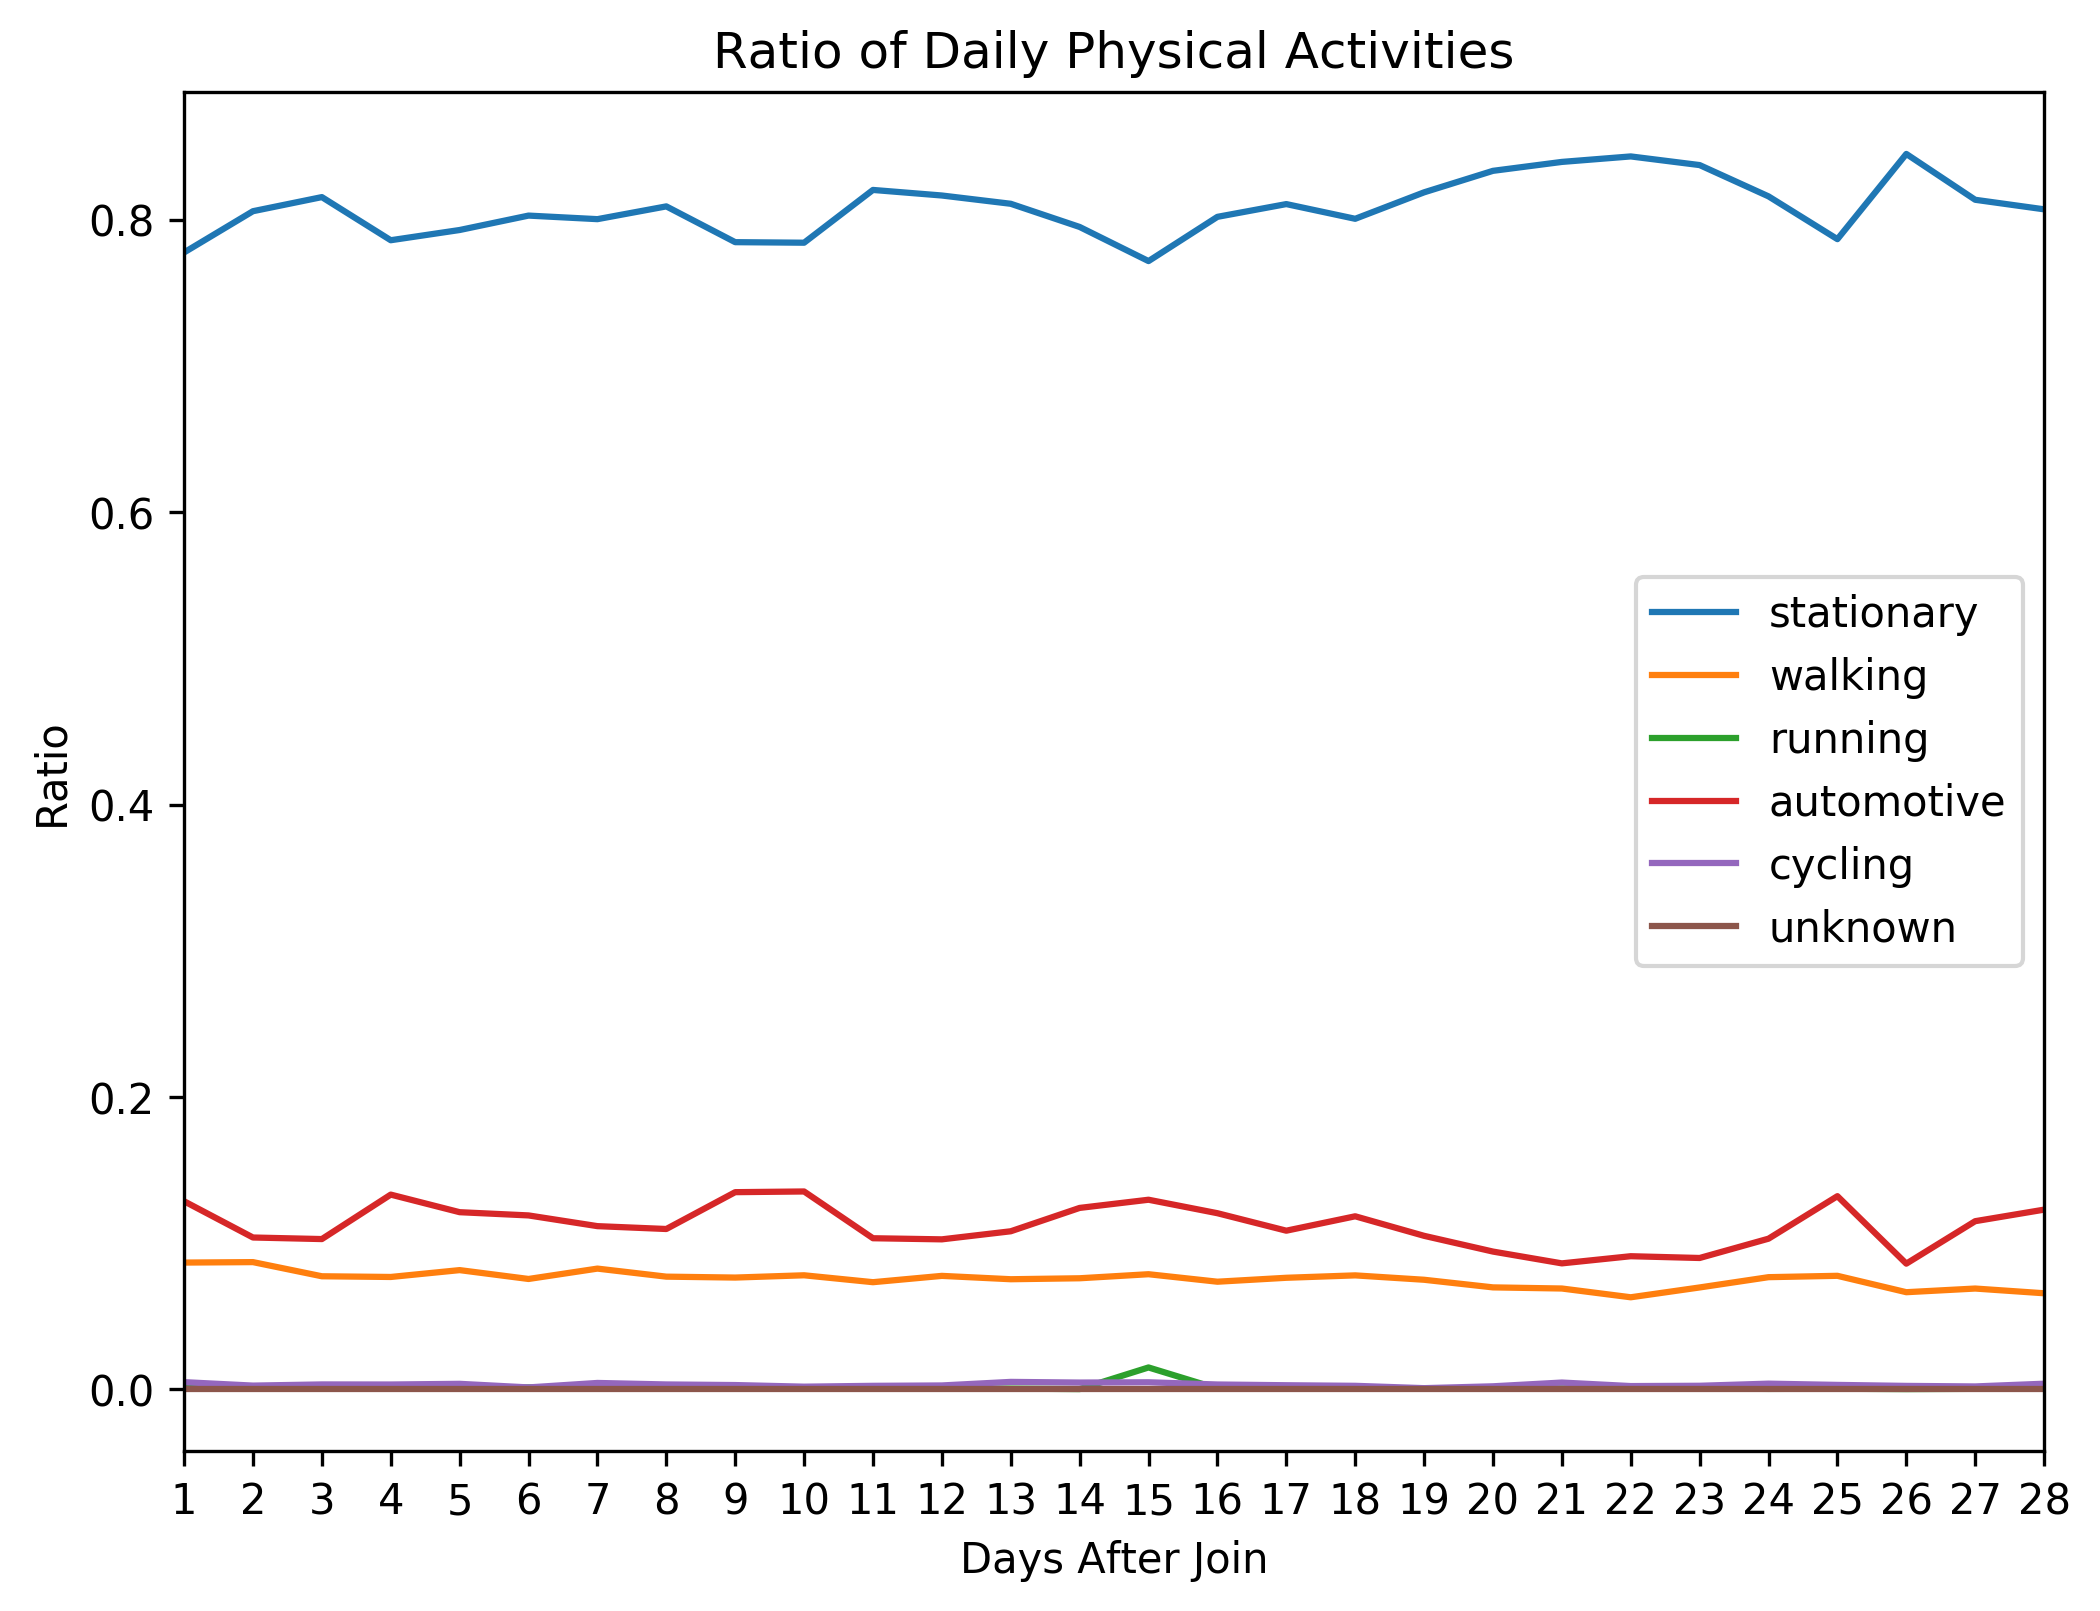

In [47]:
plt.figure(figsize=(8, 6), dpi=300)
for feature in ['stationary','walking','running','automotive','cycling','unknown']:
    x = [i+1 for i in range(28)]
    y = df_plot[feature].tolist()
    plt.plot(x,y,label = feature)
plt.xlim(1,28)
plt.xticks([i+1 for i in range(28)],[i+1 for i in range(28)])
plt.title("Ratio of Daily Physical Activities")
plt.xlabel("Days After Join")
plt.ylabel('Ratio')
plt.legend()
plt.show()

# group plot

In [12]:
df_id = pd.read_csv("/data/meditation/majid/tables/id.csv")
df_id = df_id.drop_duplicates('study_id')
df_id = df_id.drop('id', axis = 1)
df_id.columns = ['device_id','Study ID']

df_group = pd.read_csv('/data/meditation/majid/surveys/0.csv', skiprows=[1,2])[['Study ID','Group']]
df_group = df_id.merge(df_group, on = 'Study ID', how = 'left')
df_group

,device_id,Study ID,Group
0,4a23c5dc-9a50-4d46-a12d-dd94ee98270f,8415477,Experimental Condition
1,f3845ba4-8702-42cf-a14f-051c46f66b61,15027959,Active Control
2,ae02314b-a607-41b9-9507-28ffa1babed7,73386307,Active Control
3,b460f89e-fd76-46ff-a960-989d74fcb66a,87785016,Active Control
4,e5048fab-dc20-4d99-8cea-220a5a2750e0,14851895,Passive Control
...,...,...,...
64,780c9b18-72d3-4714-858d-3c91b3719155,21788465,Active Control
65,a1118578-bbb4-47ef-b784-7d5bd09ad8b5,7389236,Passive Control
66,00e17b8a-4b0f-4230-bd26-3df2853e8916,69546645,Experimental Condition
67,029e57cb-fa0d-479d-abd2-9cb5745f219d,72690342,Passive Control


In [14]:
df_plot = copy.deepcopy(df_cleaned_1_28)
df_plot = df_plot.merge(df_group[['device_id','Group']], on = 'device_id', how = 'left')
df_plot = df_plot[['stationary','walking','running','automotive','cycling','unknown','day','Group']]
df_plot['total'] = df_plot.apply(lambda x: x['stationary']+x['walking']+x['running']+x['automotive']+x['cycling']+x['unknown'],
                                axis = 1)
for feature in ['stationary','walking','running','automotive','cycling','unknown']:
    df_plot[feature] = df_plot.apply(lambda x: x[feature]/x['total'] if x['total']>0 else 0, axis = 1)

df_plot = df_plot.drop('total', axis = 1)
df_plot = df_plot.groupby(['Group','day']).mean()
df_plot = df_plot.reset_index()
df_plot


,Group,day,stationary,walking,running,automotive,cycling,unknown
0,Active Control,1,0.769677,0.079467,0.006303,0.136131,0.008422,0.0
1,Active Control,2,0.832576,0.080984,0.000829,0.082488,0.003123,0.0
2,Active Control,3,0.861664,0.062182,0.002475,0.068791,0.004888,0.0
3,Active Control,4,0.813423,0.071202,0.001400,0.107720,0.006254,0.0
4,Active Control,5,0.813558,0.077469,0.001035,0.106865,0.001072,0.0
...,...,...,...,...,...,...,...,...
79,Passive Control,24,0.797152,0.077298,0.000100,0.117775,0.007675,0.0
80,Passive Control,25,0.754344,0.071435,0.000618,0.168083,0.005519,0.0
81,Passive Control,26,0.813493,0.071558,0.000184,0.113422,0.001342,0.0
82,Passive Control,27,0.812376,0.066399,0.000989,0.117891,0.002346,0.0


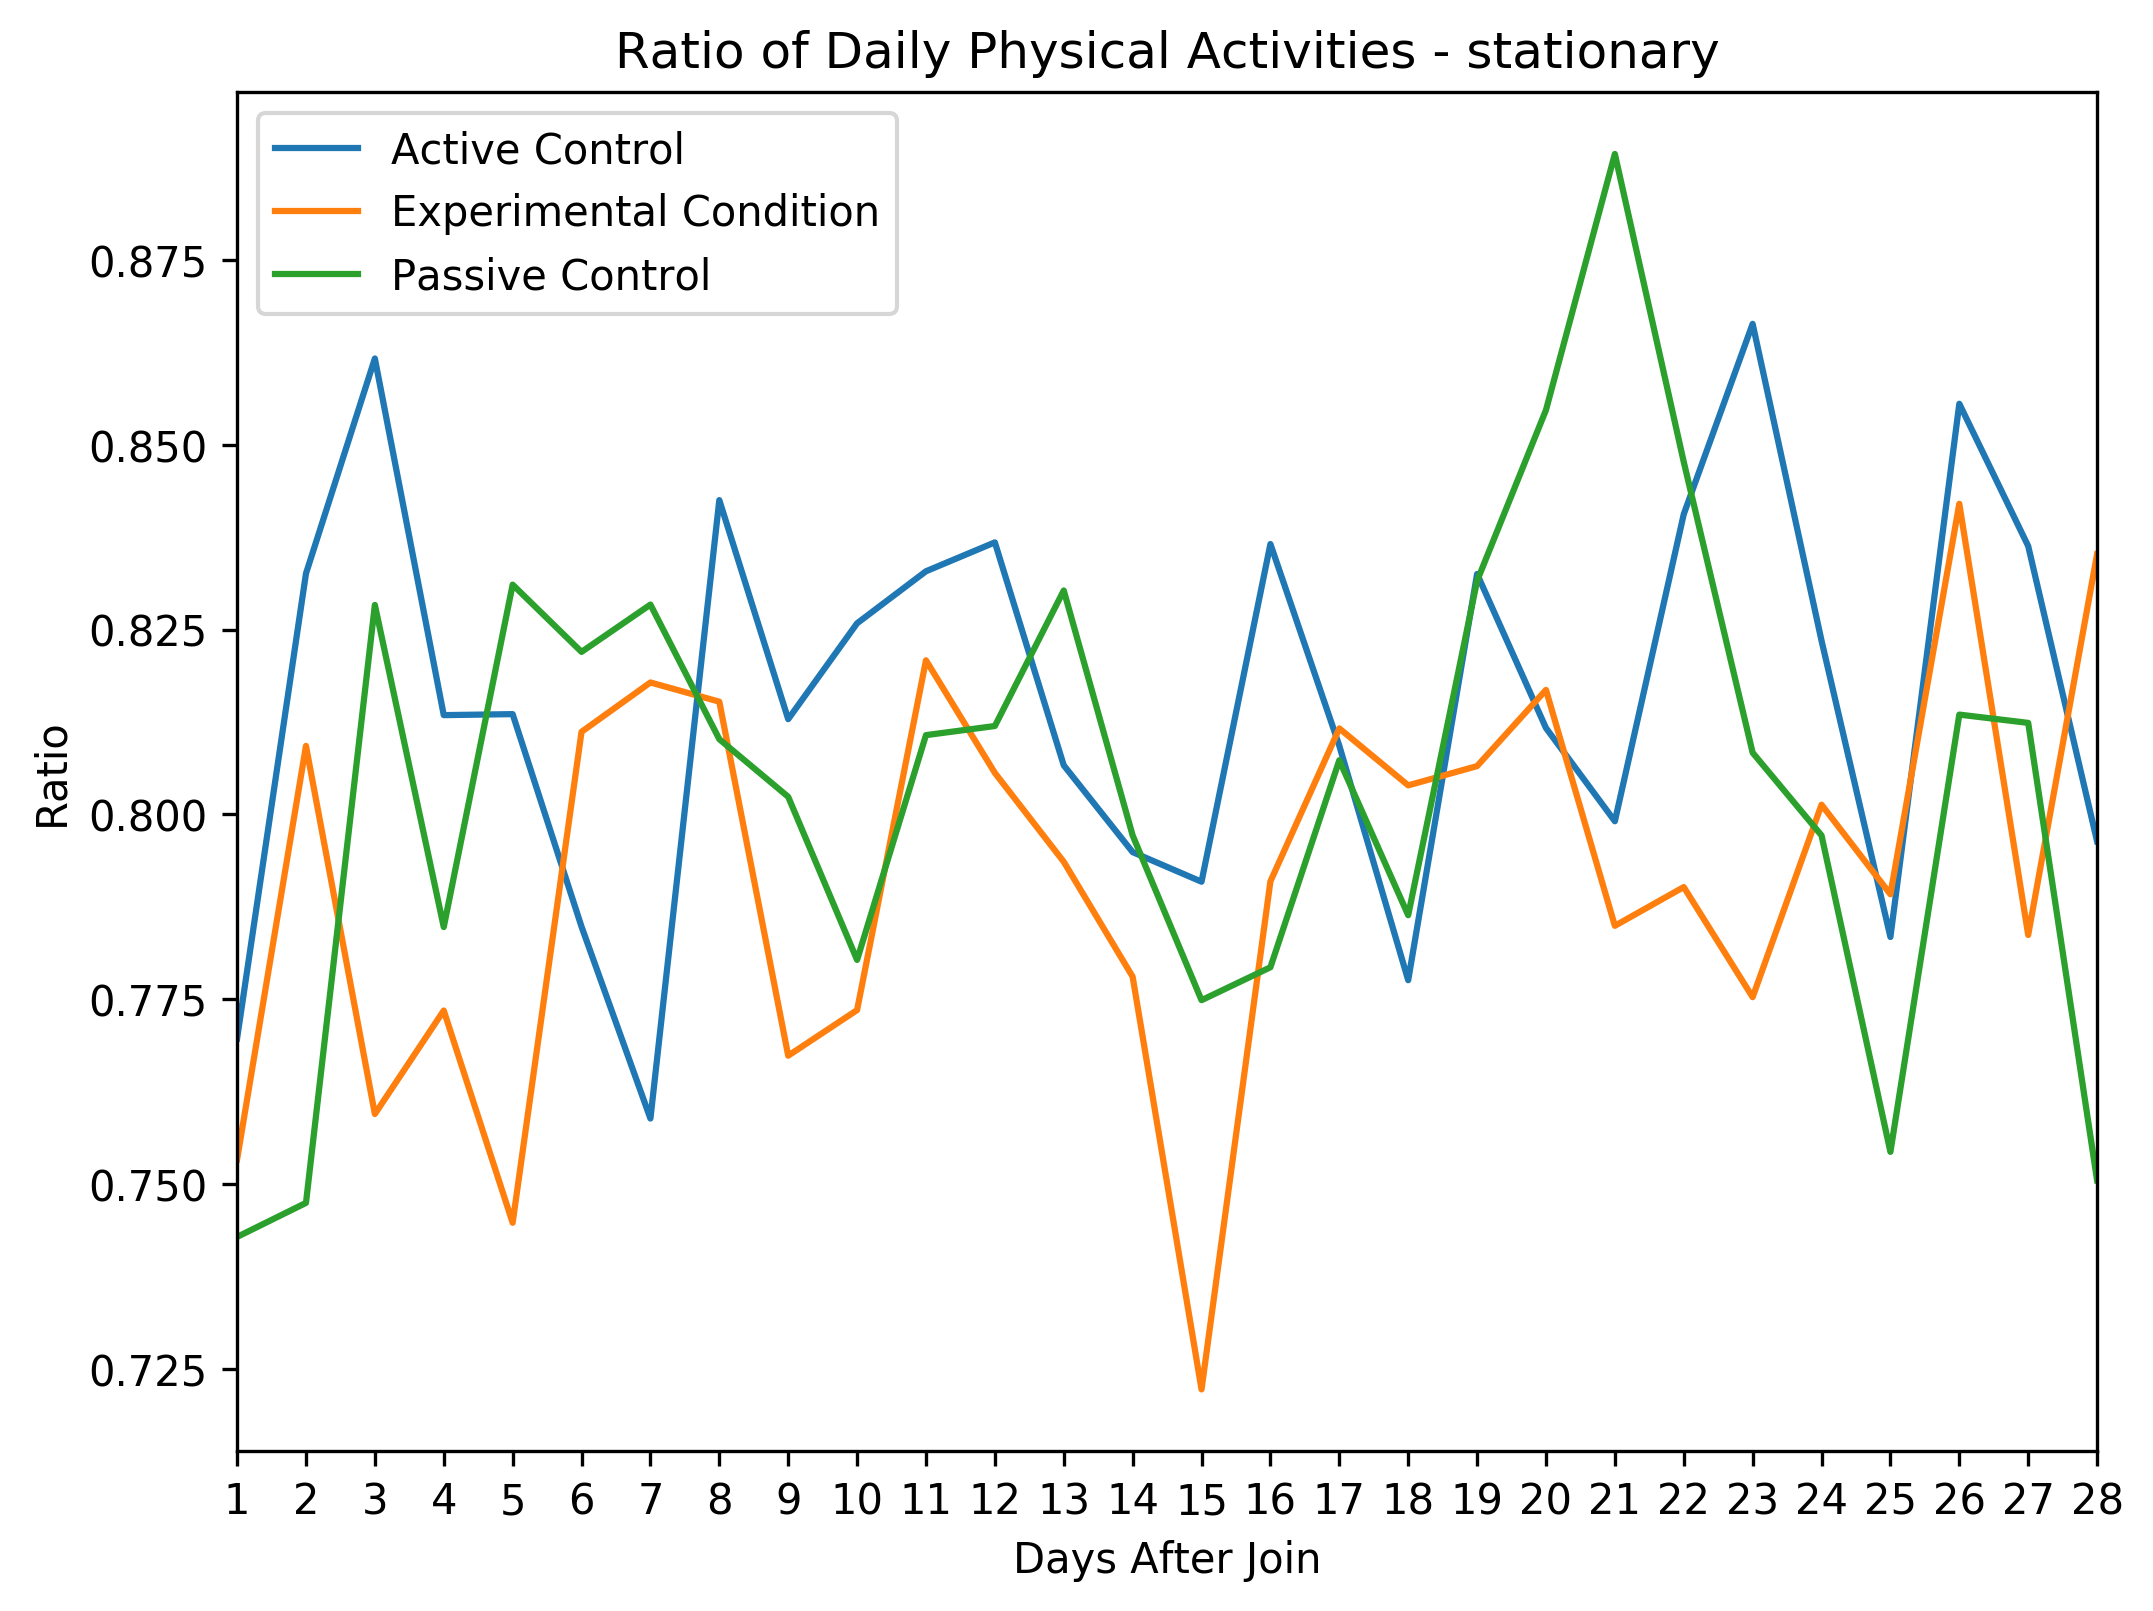

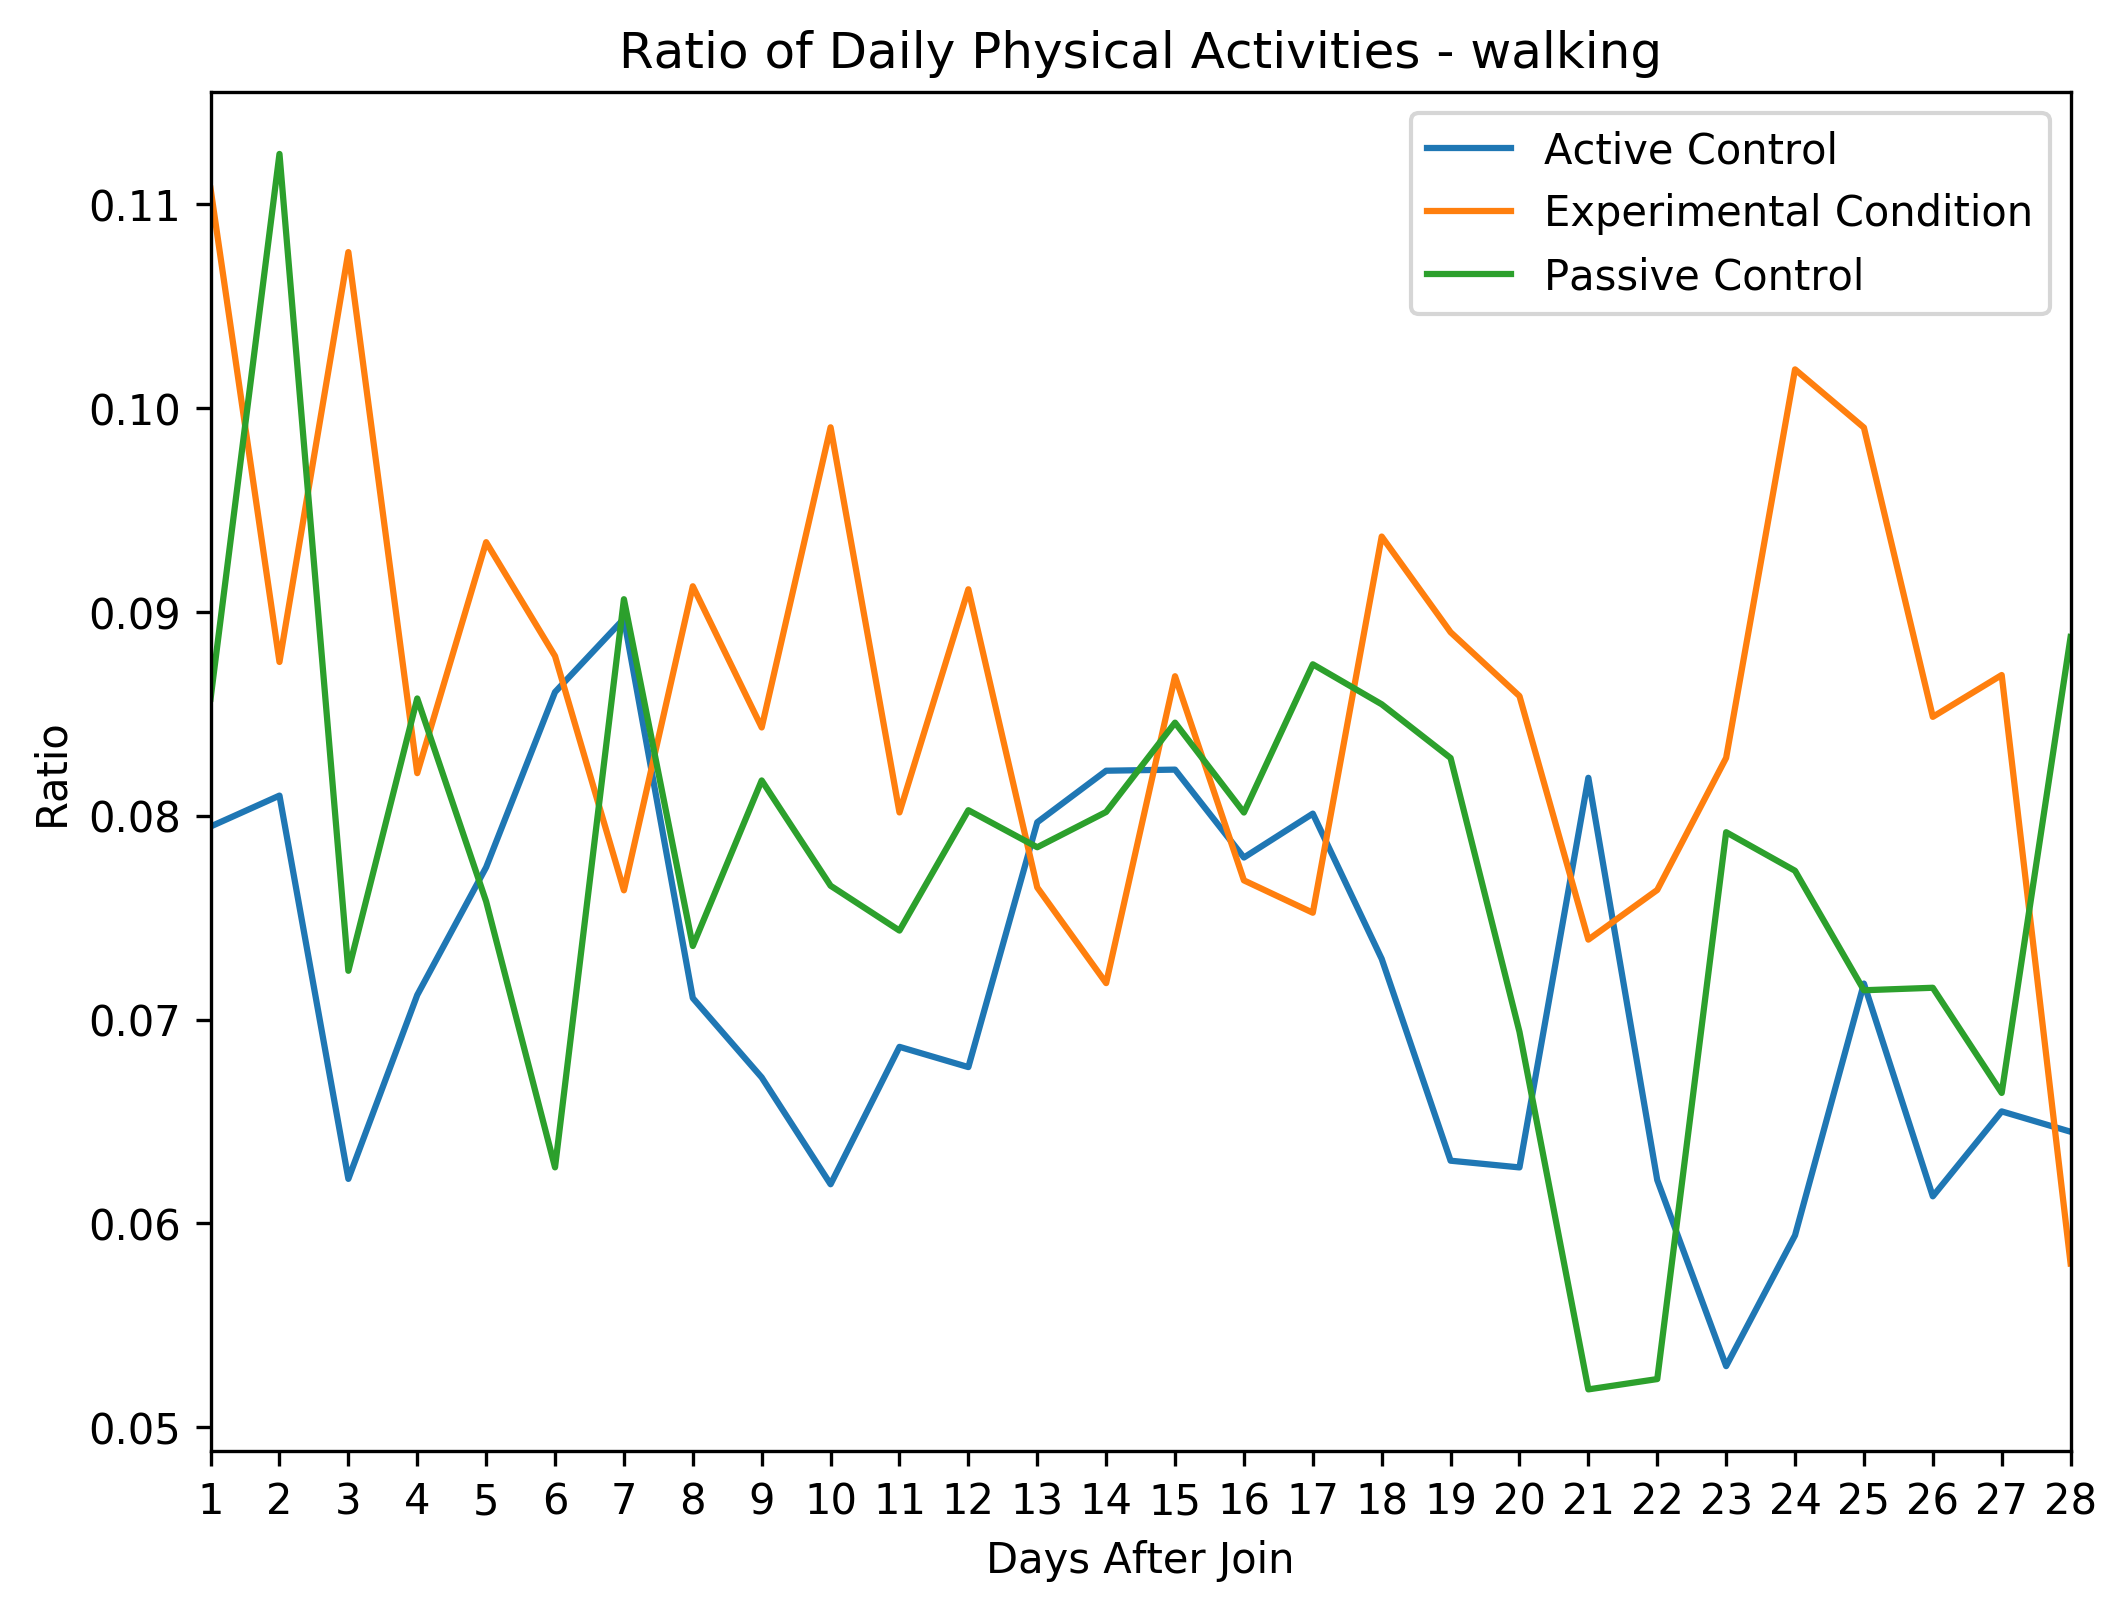

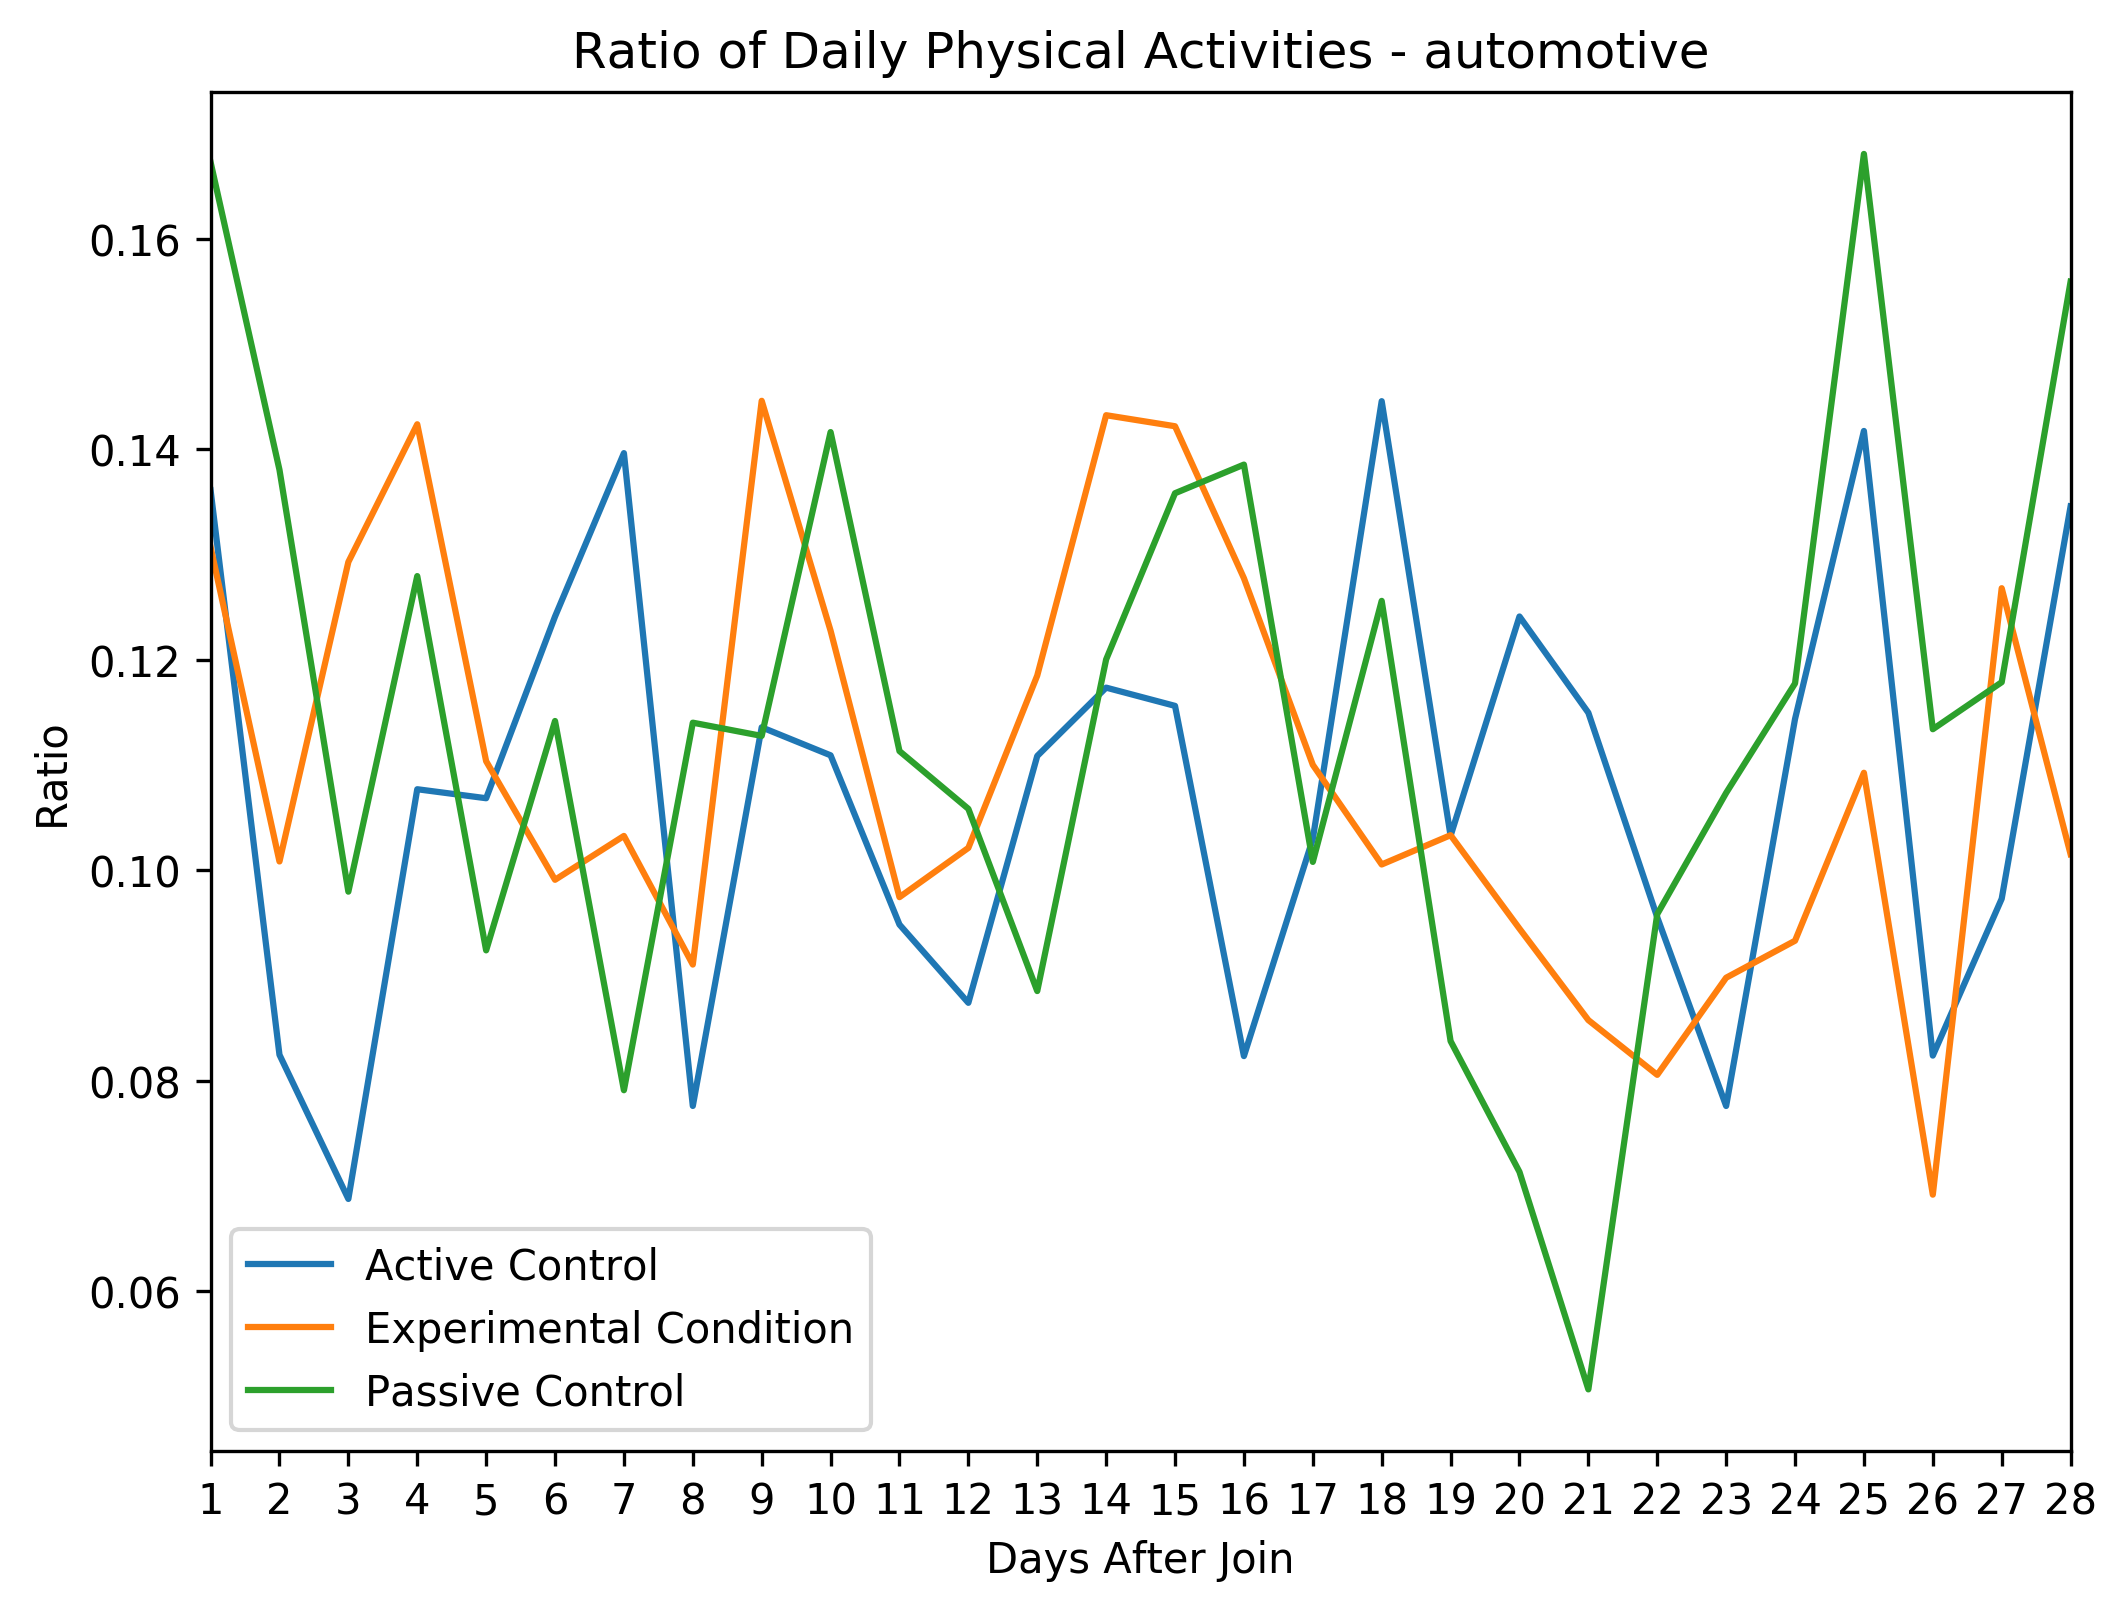

In [17]:
for feature in ['stationary','walking','automotive']:
    plt.figure(figsize=(8, 6), dpi=300)
    for group in ['Active Control', 'Experimental Condition', 'Passive Control']:
        df_target = df_plot[df_plot['Group']==group]
        x = [i+1 for i in range(28)]
        y = df_target[feature].tolist()
        plt.plot(x,y,label = group)
    plt.xlim(1,28)
    plt.xticks([i+1 for i in range(28)],[i+1 for i in range(28)])
    plt.title("Ratio of Daily Physical Activities - "+feature)
    plt.xlabel("Days After Join")
    plt.ylabel('Ratio')
    plt.legend()
    plt.show()